In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.math import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Testing models

In [ ]:
def create_model(input_shape,
                 n_classes,
                 units_LSTM=[256,128,64],
                 units_Dense=[64,32],
                 dropout_LSTM=0.2,
                 dropout_Dense=0.15,
                 learning_rate=0.001,
                 ):
    """
    Creates a LSTM model with 3 LSTM layers, 2 dense layers and an output layer
    """

    model = keras.Sequential()
    # 2 LSTM layers
    model.add(keras.layers.LSTM(units=units_LSTM[0],
                                input_shape=input_shape,
                                return_sequences=True,
                                dropout=dropout_LSTM
                                ))

    model.add(keras.layers.LSTM(units=units_LSTM[1],
                                input_shape=input_shape,
                                return_sequences=True,
                                dropout=dropout_LSTM
                                ))

    model.add(keras.layers.LSTM(units_LSTM[2]))

    # dense layers
    model.add(keras.layers.Dense(units=units_Dense[0], activation='relu'))
    model.add(keras.layers.Dropout(dropout_Dense))

    model.add(keras.layers.Dense(units_Dense[1], activation='relu'))
    model.add(keras.layers.Dropout(dropout_Dense))

    # output layer
    model.add(keras.layers.Dense(n_classes, activation='softmax'))

    #compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

#loading the dataset and encoding the labels
X_raw=np.load('/content/drive/MyDrive/Pro2/fet.npy')
y_raw=pd.read_csv('/content/drive/MyDrive/Pro2/y_raw_clean.csv')

noice_egz = ["zero", "one","two", "three",
             "four", "five", "six", "seven",
             "eight", "nine","bed", "bird",
             "cat", "dog", "happy", "house",
             "marvin", "sheila", "tree", "wow"]

y_raw['label'] = np.where(y_raw['label'].isin(noice_egz), "unknown", y_raw['label'])
encoded = pd.read_csv('/content/drive/MyDrive/Pro2/models/label_encodings.csv')

y_all = y_raw.merge(encoded, left_on='label', right_on='name',how="left")['index']

X_train, X_test, y_train, y_test=train_test_split(X_raw,y_all,stratify=y_all,test_size=0.25)

input_shape = (X_train.shape[1], X_train.shape[2]) # 20,98
n_classes=len(np.unique(y_train)) #12

In [ ]:
dropout_LSTM=np.arange(start=0,stop=0.5,step=0.1)
learning_rate=[10.0**(-i) for i in np.arange(start=1,stop=5,step=1)]
units_LSTM=[[128,128,128],[256,128,64],[64,64,64],[512,256,128]]
n_epochs=35
callback=EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    restore_best_weights=True,
)

In [ ]:
#ans_list=[]
for dropout_id,dropout in tqdm(enumerate(dropout_LSTM)):
    for lr_id,lr in tqdm(enumerate(learning_rate)):
        for unit_id,unit in enumerate(units_LSTM):
            model=create_model(input_shape=input_shape,
                              n_classes=n_classes,
                              units_LSTM=unit,
                              units_Dense=[unit[2],32],
                              dropout_LSTM=dropout,
                              dropout_Dense=0.15,
                              learning_rate=lr)
            history=model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32,callbacks=callback,epochs=n_epochs,verbose=0)
            #ans_list.append((dropout_id,lr_id,unit_id,history.history))
            model.save('/content/drive/MyDrive/Pro2/models/grid_search/model'+ str(dropout_id)+str(lr_id)+str(unit_id)+".hdf5")
            print(str(dropout_id)+str(lr_id)+str(unit_id)+" done\n")

In [ ]:
results_dataframe=pd.DataFrame(columns=["dropout_id","lr_id","unit_id","acc"])
for dropout_id,dropout in tqdm(enumerate(dropout_LSTM)):
    for lr_id,lr in enumerate(learning_rate):
        for unit_id,unit in enumerate(units_LSTM):
          model_id=str(dropout_id)+str(lr_id)+str(unit_id)
          model=keras.models.load_model('/content/drive/MyDrive/Pro2/models/grid_search/model'+ model_id+".hdf5")
          y_pred=model.predict(X_test).argmax(axis=1)
          accuracy=(y_pred==y_test).mean()
          results_dataframe=results_dataframe.append({'dropout_id':dropout_id, 'lr_id': lr_id, 'unit_id': unit_id,'acc':accuracy},ignore_index=True)
results_dataframe.to_csv('/content/drive/MyDrive/Pro2/LSTM_models_results.csv')

### Learning rate comparisson

In [ ]:
results_dataframe=pd.read_csv('/content/drive/MyDrive/Pro2/LSTM_models_results.csv',index_col=0)
results_dataframe.sort_values(by='acc',ascending=False).head(10)

,dropout_id,lr_id,unit_id,acc
31,1.0,3.0,3.0,0.917383
43,2.0,2.0,3.0,0.913943
47,2.0,3.0,3.0,0.911425
59,3.0,2.0,3.0,0.911118
27,1.0,2.0,3.0,0.905037
11,0.0,2.0,3.0,0.900123
25,1.0,2.0,1.0,0.898587
8,0.0,2.0,0.0,0.897789
41,2.0,2.0,1.0,0.895393
40,2.0,2.0,0.0,0.894472


In [ ]:
tmp=results_dataframe.groupby("lr_id").apply(lambda x: x.sort_values(["acc"], ascending = False)).reset_index(drop=True)
tmp.groupby('lr_id').head(1).sort_values(by='acc',ascending=False)

,dropout_id,lr_id,unit_id,acc
60,1.0,3.0,3.0,0.917383
40,2.0,2.0,3.0,0.913943
20,1.0,1.0,1.0,0.635319
0,0.0,0.0,0.0,0.630221


In [ ]:
lr_train_acc=[]
lr_train_loss=[]
lr_val_acc=[]
lr_val_loss=[]
for id,lr in tqdm(enumerate(learning_rate)):
    units=units_LSTM[round(id)]
    dropout=dropout_LSTM[round(id)]
    if id==2.0:
      units=units_LSTM[3]
    elif id==3.0:
      dropout=dropout_LSTM[1]
    model=create_model(input_shape=input_shape,
                              n_classes=n_classes,
                              units_LSTM=units,
                              units_Dense=[units[2],32],
                              dropout_LSTM=dropout,
                              dropout_Dense=0.15,
                              learning_rate=lr)
    history=model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32,epochs=30,verbose=0)
    lr_train_acc.append(history.history['accuracy'])
    lr_train_loss.append(history.history['loss'])
    lr_val_acc.append(history.history['val_accuracy'])
    lr_val_loss.append(history.history['val_loss'])

4it [28:54, 433.62s/it]


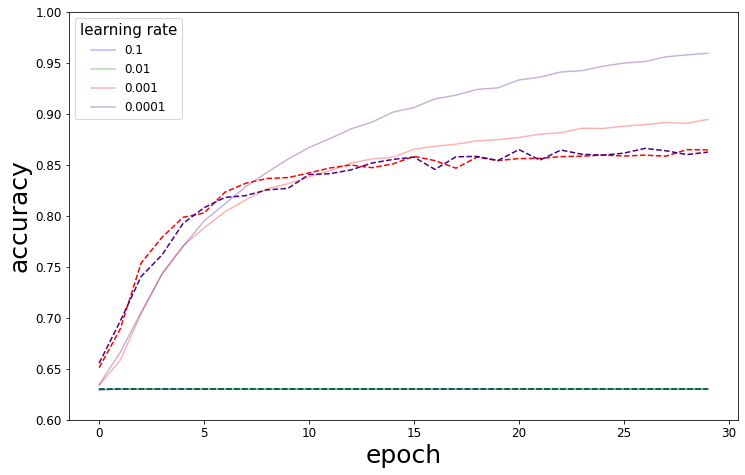

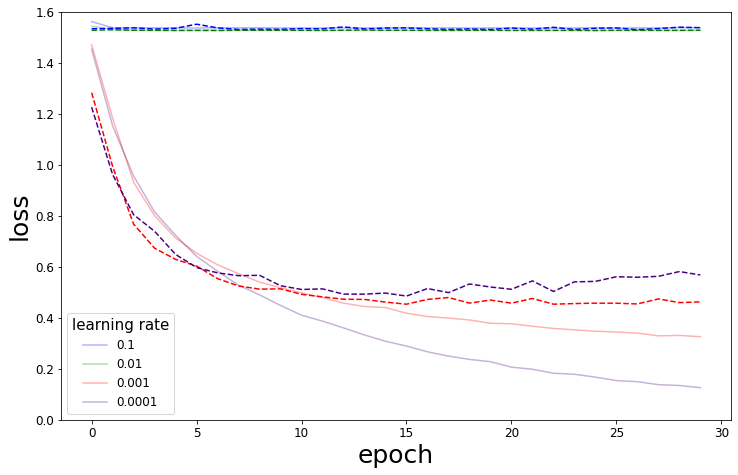

In [ ]:
colors=['b','g','r','indigo']
fig, ax = plt.subplots(figsize=(12,7.5))
for num,item in enumerate(lr_train_acc):
    plt.plot(item,color=colors[num], alpha=0.3)
for num,item in enumerate(lr_val_acc):
    plt.plot(item,color=colors[num],linestyle='dashed')    
plt.ylabel('accuracy',fontsize=25)
plt.xlabel('epoch',fontsize=25)

plt.legend(learning_rate, loc='upper left',fontsize=12,title="learning rate",title_fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0.6,1])
plt.show()

fig, ax = plt.subplots(figsize=(12,7.5))
for num,item in enumerate(lr_train_loss):
    plt.plot(item,color=colors[num], alpha=0.3)
for num,item in enumerate(lr_val_loss):
    plt.plot(item,color=colors[num],linestyle='dashed')    
plt.ylabel('loss',fontsize=25)
plt.xlabel('epoch',fontsize=25)

plt.legend(learning_rate, loc='lower left',fontsize=12,title="learning rate",title_fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0,1.6])
plt.show()

### Dropout comparisson

In [ ]:
tmp=results_dataframe.groupby("dropout_id").apply(lambda x: x.sort_values(["acc"], ascending = False)).reset_index(drop=True)
tmp.groupby('dropout_id').head(1).sort_values(by='acc',ascending=False)

,dropout_id,lr_id,unit_id,acc
16,1.0,3.0,3.0,0.917383
32,2.0,2.0,3.0,0.913943
48,3.0,2.0,3.0,0.911118
0,0.0,2.0,3.0,0.900123
64,4.0,2.0,0.0,0.894226


In [ ]:
dropout_train_acc=[]
dropout_train_loss=[]
dropout_val_acc=[]
dropout_val_loss=[]
for id,dropout in tqdm(enumerate(dropout_LSTM)):
    units=units_LSTM[3]
    if id==1.0:
      lr=learning_rate[3]
    elif id==4.0:
      units=units_LSTM[0]
      lr=learning_rate[2]
    else:
      lr=learning_rate[2]
    model=create_model(input_shape=input_shape,
                              n_classes=n_classes,
                              units_LSTM=units,
                              units_Dense=[units[2],32],
                              dropout_LSTM=dropout,
                              dropout_Dense=0.15,
                              learning_rate=lr)
    history=model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32,epochs=30,verbose=0)
    dropout_train_acc.append(history.history['accuracy'])
    dropout_train_loss.append(history.history['loss'])
    dropout_val_acc.append(history.history['val_accuracy'])
    dropout_val_loss.append(history.history['val_loss'])

5it [37:00, 444.08s/it]


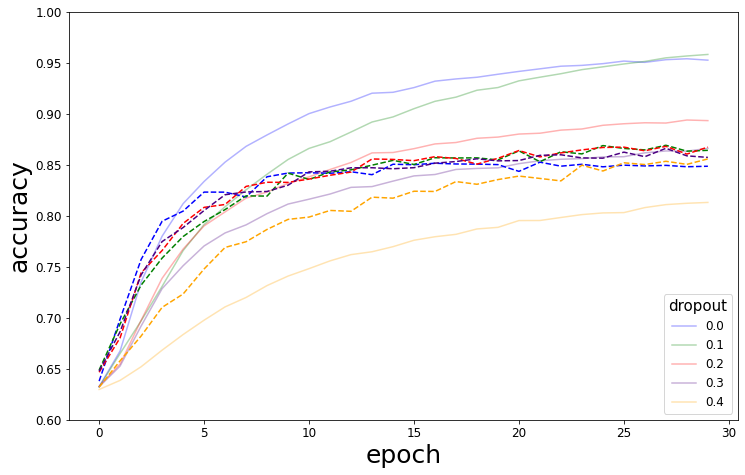

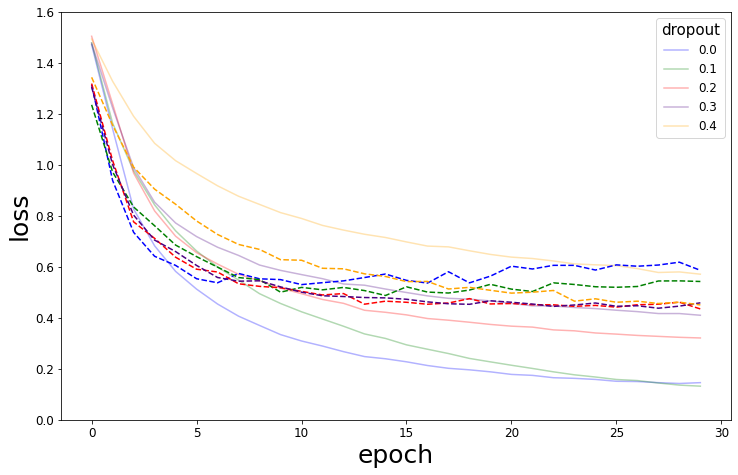

In [ ]:
colors=['b','g','r','indigo','orange']
fig, ax = plt.subplots(figsize=(12,7.5))
for num,item in enumerate(dropout_train_acc):
    plt.plot(item,color=colors[num], alpha=0.3)
for num,item in enumerate(dropout_val_acc):
    plt.plot(item,color=colors[num],linestyle='dashed')    
plt.ylabel('accuracy',fontsize=25)
plt.xlabel('epoch',fontsize=25)
dropout_LSTM2=dropout_LSTM
dropout_LSTM2[3]=0.3
plt.legend(dropout_LSTM2, loc='lower right',fontsize=12,title="dropout",title_fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0.6,1])
plt.show()

fig, ax = plt.subplots(figsize=(12,7.5))
for num,item in enumerate(dropout_train_loss):
    plt.plot(item,color=colors[num], alpha=0.3)
for num,item in enumerate(dropout_val_loss):
    plt.plot(item,color=colors[num],linestyle='dashed')    
plt.ylabel('loss',fontsize=25)
plt.xlabel('epoch',fontsize=25)

plt.legend(dropout_LSTM2, loc='upper right',fontsize=12,title="dropout",title_fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0,1.6])
plt.show()

### Units comparisson

In [ ]:
tmp=results_dataframe.groupby("unit_id").apply(lambda x: x.sort_values(["acc"], ascending = False)).reset_index(drop=True)
tmp.groupby('unit_id').head(1).sort_values(by='acc',ascending=False)

,dropout_id,lr_id,unit_id,acc
60,1.0,3.0,3.0,0.917383
20,1.0,2.0,1.0,0.898587
0,0.0,2.0,0.0,0.897789
40,1.0,2.0,2.0,0.883354


In [ ]:
unit_train_acc=[]
unit_train_loss=[]
unit_val_acc=[]
unit_val_loss=[]
for id,unit in tqdm(enumerate(units_LSTM)):
    dropout=dropout_LSTM[1]
    lr=learning_rate[2]
    if id==3.0:
      lr=learning_rate[3]
    elif id==0.0:
      dropout=dropout_LSTM[0]
    model=create_model(input_shape=input_shape,
                              n_classes=n_classes,
                              units_LSTM=unit,
                              units_Dense=[unit[2],32],
                              dropout_LSTM=dropout,
                              dropout_Dense=0.15,
                              learning_rate=lr)
    history=model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32,epochs=30,verbose=0)
    unit_train_acc.append(history.history['accuracy'])
    unit_train_loss.append(history.history['loss'])
    unit_val_acc.append(history.history['val_accuracy'])
    unit_val_loss.append(history.history['val_loss'])

4it [27:38, 414.70s/it]


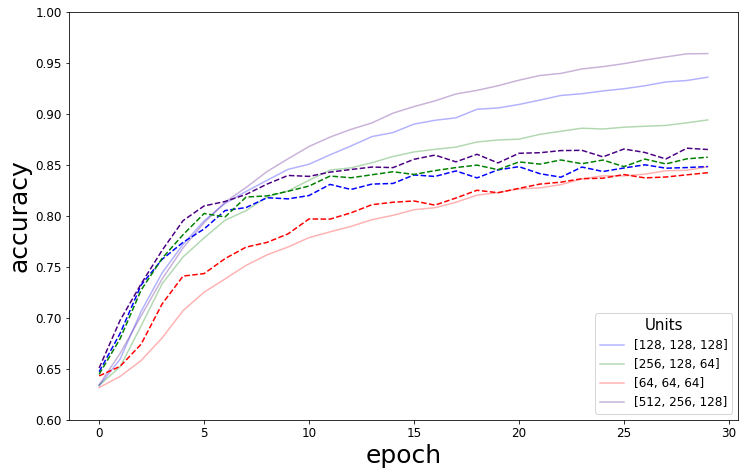

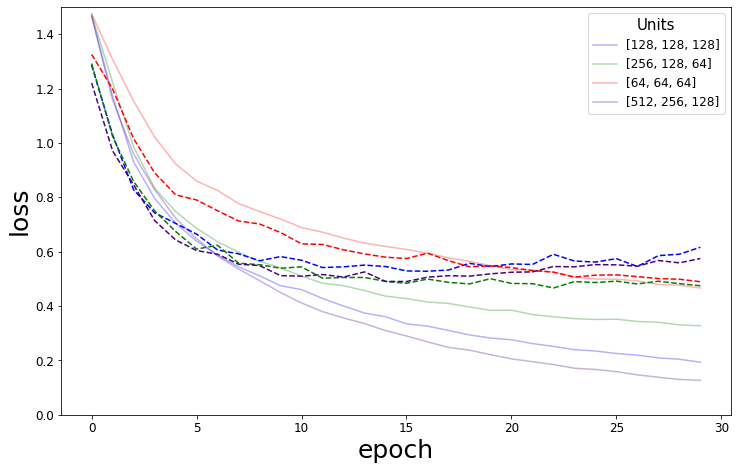

In [ ]:
colors=['b','g','r','indigo','orange']
fig, ax = plt.subplots(figsize=(12,7.5))
for num,item in enumerate(unit_train_acc):
    plt.plot(item,color=colors[num], alpha=0.3)
for num,item in enumerate(unit_val_acc):
    plt.plot(item,color=colors[num],linestyle='dashed')    
plt.ylabel('accuracy',fontsize=25)
plt.xlabel('epoch',fontsize=25)
plt.legend(units_LSTM, loc='lower right',fontsize=12,title="Units",title_fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0.6,1])
plt.show()

fig, ax = plt.subplots(figsize=(12,7.5))
for num,item in enumerate(unit_train_loss):
    plt.plot(item,color=colors[num], alpha=0.3)
for num,item in enumerate(unit_val_loss):
    plt.plot(item,color=colors[num],linestyle='dashed')    
plt.ylabel('loss',fontsize=25)
plt.xlabel('epoch',fontsize=25)

plt.legend(units_LSTM, loc='upper right',fontsize=12,title="Units",title_fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0,1.5])
plt.show()

Epoch 1/35
1527/1527 [==============================] - 21s 11ms/step - loss: 1.4942 - accuracy: 0.6333 - val_loss: 1.2662 - val_accuracy: 0.6497
Epoch 2/35
1527/1527 [==============================] - 16s 11ms/step - loss: 1.1843 - accuracy: 0.6625 - val_loss: 0.9918 - val_accuracy: 0.6939
Epoch 3/35
1527/1527 [==============================] - 16s 10ms/step - loss: 0.9860 - accuracy: 0.6978 - val_loss: 0.8444 - val_accuracy: 0.7323
Epoch 4/35
1527/1527 [==============================] - 16s 11ms/step - loss: 0.8500 - accuracy: 0.7321 - val_loss: 0.7361 - val_accuracy: 0.7672
Epoch 5/35
1527/1527 [==============================] - 16s 11ms/step - loss: 0.7425 - accuracy: 0.7629 - val_loss: 0.6697 - val_accuracy: 0.7821
Epoch 6/35
1527/1527 [==============================] - 16s 10ms/step - loss: 0.6612 - accuracy: 0.7904 - val_loss: 0.6351 - val_accuracy: 0.7993
Epoch 7/35
1527/1527 [==============================] - 16s 11ms/step - loss: 0.5921 - accuracy: 0.8107 - val_loss: 0.5732 -

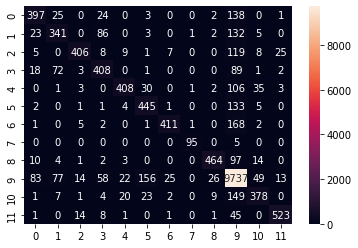

<tf.Tensor: shape=(12, 12), dtype=int32, numpy=
array([[ 397,   25,    0,   24,    0,    3,    0,    0,    2,  138,    0,
           1],
       [  23,  341,    0,   86,    0,    3,    0,    1,    2,  132,    5,
           0],
       [   5,    0,  406,    8,    9,    1,    7,    0,    0,  119,    8,
          25],
       [  18,   72,    3,  408,    0,    1,    0,    0,    0,   89,    1,
           2],
       [   0,    1,    3,    0,  408,   30,    0,    1,    2,  106,   35,
           3],
       [   2,    0,    1,    1,    4,  445,    1,    0,    0,  133,    5,
           0],
       [   1,    0,    5,    2,    0,    1,  411,    1,    0,  168,    2,
           0],
       [   0,    0,    0,    0,    0,    0,    0,   95,    0,    5,    0,
           0],
       [  10,    4,    1,    2,    3,    0,    0,    0,  464,   97,   14,
           0],
       [  83,   77,   14,   58,   22,  156,   25,    0,   26, 9737,   49,
          13],
       [   1,    7,    1,    4,   20,   23,    2,    0,    9, 

In [ ]:
model=create_model(input_shape=input_shape,
                   n_classes=n_classes,
                   units_LSTM=units_LSTM[3],
                   units_Dense=[units_LSTM[3][2],32],
                   dropout_LSTM=dropout_LSTM[1],
                   dropout_Dense=0.15,
                   learning_rate=learning_rate[3])
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32,callbacks=callback,epochs=n_epochs,verbose=1)
y_pred=model.predict(X_test).argmax(axis=1)
conf_matrix=confusion_matrix(labels=y_test,predictions=y_pred)
plt.plot(figsize=(20,18))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.show()
conf_matrix